In [70]:
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
import numpy as np

df = pd.read_csv("ds_salaries_features_v1.csv")

X = df.drop(columns=["salary_in_usd"])
y = df["salary_in_usd"]

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42
)


In [71]:
numeric_features = [
    "work_year",
    "experience_level_ord",
    "company_size_ord",
    "remote_ratio",
    "fully_remote_flag",
    "is_full_time",
    "leadership_flag"
]

In [72]:
categorical_features = [
    "role_category",
    "company_country",
    "employment_type_cat"
]

In [73]:
# Check for overlap (must be empty)
set(numeric_features) & set(categorical_features)


set()

In [74]:
# Check no unexpected columns
expected = set(numeric_features + categorical_features)
extra = set(X.columns) - expected
extra


{'company_location', 'company_size', 'employment_type', 'experience_level'}

In [75]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", "passthrough", numeric_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features)
    ],
    remainder="drop"  # ⬅️ THIS LINE FIXES YOUR ERROR
)

In [76]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression

model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", LinearRegression())
])


In [77]:
model.fit(X_train, y_train)


,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocessor', ...), ('regressor', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformer

In [78]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

mae, rmse, r2


(28490.12787147977, np.float64(41203.64644782002), 0.5570228735930003)

In [79]:
pd.DataFrame({
    "Actual Salary": y_test.values[:10],
    "Predicted Salary": y_pred[:10]
})


,Actual Salary,Predicted Salary
0,140250,148394.442746
1,135000,148394.442746
2,100000,98973.787513
3,270000,201344.101302
4,26005,140837.266039
5,153000,132867.405421
6,51321,23293.656782
7,49646,23671.108112
8,76940,55336.740921
9,59102,-6836.068352


In [81]:
X = df.drop(columns=["salary_in_usd"])
y = np.log1p(df["salary_in_usd"])

model.fit(X,y)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocessor', ...), ('regressor', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformer

In [82]:
preprocessor = model.named_steps["preprocessor"]

num_features = numeric_features

cat_encoder = preprocessor.named_transformers_["cat"]
cat_features = cat_encoder.get_feature_names_out(categorical_features)

all_feature_names = np.concatenate([num_features, cat_features])

In [83]:
coefficients = model.named_steps["regressor"].coef_

feature_importance = pd.DataFrame({
    "feature": all_feature_names,
    "coefficient": coefficients
})


In [84]:
feature_importance["abs_coef"] = feature_importance["coefficient"].abs()
feature_importance = feature_importance.sort_values("abs_coef", ascending=False)


In [85]:
feature_importance.head(15)


,feature,coefficient,abs_coef
41,company_country_IR,-2.347368,2.347368
65,company_country_VN,-2.110910,2.110910
30,company_country_DZ,2.085579,2.085579
40,company_country_IQ,1.228161,1.228161
62,company_country_UA,-1.097087,1.097087
19,company_country_AU,1.013077,1.013077
39,company_country_IL,0.998148,0.998148
49,company_country_MX,-0.943606,0.943606
64,company_country_USA,0.926784,0.926784
21,company_country_BR,-0.926275,0.926275


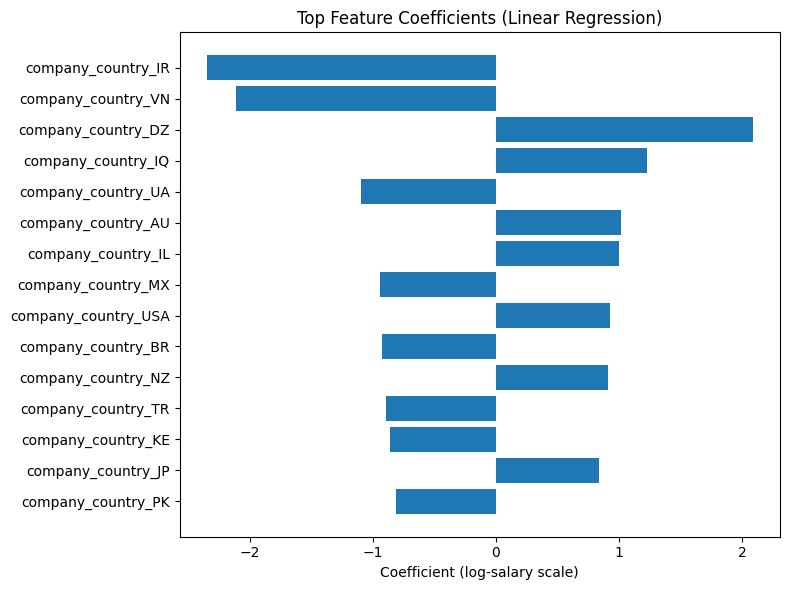

In [86]:
import matplotlib.pyplot as plt

top_n = 15
top_features = feature_importance.head(top_n)

plt.figure(figsize=(8, 6))
plt.barh(top_features["feature"], top_features["coefficient"])
plt.gca().invert_yaxis()
plt.title("Top Feature Coefficients (Linear Regression)")
plt.xlabel("Coefficient (log-salary scale)")
plt.tight_layout()
plt.show()


## Step 6: Tree-Based Models (Random Forest / Gradient Boosting)

In [87]:
# PURPOSE:
# In this section, we upgrade from a linear regression baseline
# to tree-based models that can capture nonlinear relationships
# in salary data (e.g., seniority jumps, role interactions).

# IMPORTANT:
# - We reuse the same feature-engineered dataset
# - We reuse the same preprocessing pipeline (ColumnTransformer)
# - The ONLY thing that changes is the regression model

# This ensures a fair comparison with the baseline model.

df = pd.read_csv("ds_salaries_features_v1.csv")

preprocessor = ColumnTransformer(
    transformers=[
        ("num", "passthrough", numeric_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features)
    ],
    remainder="drop"  
)



In [90]:
# STEP 6.1: Prepare features (X) and target (y)

# - X should include ALL feature-engineered columns
# - y should be the salary target
# - If using log-salary modeling, apply the same transformation
#   used in the baseline model

# DO NOT:
# - Re-engineer features
# - Change column names
# - Include the target column in X

X = df[[
    "work_year",
    "experience_level_ord",
    "company_size_ord",
    "remote_ratio",
    "fully_remote_flag",
    "is_full_time",
    "leadership_flag",
    "role_category",
    "company_country",
    "employment_type_cat"
]]

y = df["salary_in_usd"]

In [92]:
# STEP 6.2: Create train/test split

# - Use the same split strategy as the baseline model
# - This allows direct comparison between models
# - Keep the test set untouched

# NOTE:
# If you saved a random_state earlier, reuse it here
# for reproducibility.

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42
)



In [97]:
# STEP 6.3: Build a Random Forest regression pipeline

# PIPELINE STRUCTURE:
# 1. Preprocessor:
#    - Numeric features: passthrough
#    - Categorical features: OneHotEncoder
# 2. Regressor:
#    - Random Forest Regressor

# IMPORTANT:
# - Do NOT change preprocessing
# - Only swap the regression model
# - Use reasonable default hyperparameters initially

from sklearn.ensemble import RandomForestRegressor

rf_model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", RandomForestRegressor(
        n_estimators=100,
        random_state=42, 
        n_jobs=1
    ))
])

In [98]:
# STEP 6.4: Train the Random Forest model

# - Fit the pipeline using X_train and y_train
# - This model will learn nonlinear relationships
#   that linear regression cannot capture

# EXPECTATION:
# - Training will take longer than linear regression
# - No errors related to string columns should appear

rf_model.fit(X_train, y_train)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocessor', ...), ('regressor', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformer

In [ ]:
# STEP 6.5: Generate salary predictions on the test set

# - Predict using the trained Random Forest pipeline
# - If the target was log-transformed:
#   - Convert predictions back to salary scale

# GOAL:
# - Compare predictions against actual salaries


In [ ]:
# STEP 6.6: Evaluate Random Forest performance

# Compute the same metrics used for the baseline model:
# - Mean Absolute Error (MAE)
# - Root Mean Squared Error (RMSE)
# - R-squared (R²)

# COMPARISON:
# - Compare these metrics against linear regression
# - Expect improved performance, especially on high salaries


In [ ]:
# STEP 6.7: Sanity check Random Forest predictions

# - Create a small table of actual vs predicted salaries
# - Inspect edge cases:
#   - Very low salaries
#   - Very high salaries
#   - Leadership roles

# EXPECTATION:
# - Fewer extreme misses than linear regression
# - No negative salary predictions


In [ ]:
# STEP 6.8: Extract feature importance from Random Forest

# - Tree-based models provide native feature importance
# - Importance scores indicate how often features are used
#   to split decision trees

# PROCESS:
# - Extract importance values from the trained model
# - Map them back to encoded feature names
# - Rank features by importance

# GOAL:
# - Validate which features most influence salary predictions


### Interpretation: Random Forest Model

- Identify which features dominate salary prediction
- Compare importance rankings to linear model coefficients
- Note improvements in modeling nonlinear effects
- Document insights for later comparison with Gradient Boosting
